In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold
from sklearn import preprocessing
!pip install optuna
import optuna
import xgboost as xgb
import functools
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

In [ ]:
api_token = {"username":"watsons","key":"dc7da47ca9aa5e696b65f97c16fd627b"}
import json
import zipfile
import os
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle competitions download -c tabular-playground-series-jun-2021 --force
!unzip \*.zip  && rm *.zipy

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
train

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,0,0,0,3,0,1,0,0,3,3,1,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,11,0,0,0,0,0,9,0,0,0,0,0,0,3,0,1,3,0,0,0,0,0,0,0,1,1,0,0,3,0,0,0,0,0,0,2,0,0,Class_6
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,Class_6
2,2,0,0,0,0,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,5,4,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,5,0,5,0,1,0,0,0,1,0,0,1,0,7,0,1,1,0,3,4,0,0,1,3,0,2,0,0,8,0,0,0,0,1,0,0,0,0,Class_2
3,3,0,0,7,0,1,5,2,2,0,1,2,0,5,0,0,4,0,0,22,2,1,0,0,0,0,3,0,37,0,1,3,13,0,10,0,3,1,1,0,7,0,0,2,0,1,0,0,0,0,0,0,10,0,0,25,1,0,1,2,0,2,0,7,0,0,0,0,4,0,2,2,0,4,3,0,Class_8
4,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,0,1,6,0,1,32,0,6,0,0,2,0,1,4,0,0,0,0,2,4,0,0,44,0,0,2,0,0,0,3,0,34,0,6,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,9,0,0,2,2,0,1,2,0,0,0,1,0,1,1,0,0,0,4,1,0,Class_6
199996,199996,0,2,0,0,1,0,0,0,0,0,2,0,2,0,0,0,0,0,1,1,0,3,0,0,0,0,1,1,0,0,0,7,0,0,0,1,0,2,0,1,0,0,2,9,0,0,0,0,0,0,3,0,0,0,0,0,0,1,0,1,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,Class_6
199997,199997,1,2,0,0,0,2,0,1,8,4,10,1,1,1,2,1,0,0,0,6,0,9,0,14,0,4,7,2,53,0,6,1,1,0,1,0,0,2,2,0,1,0,4,12,2,0,0,0,0,0,2,1,0,0,89,0,6,5,1,0,0,3,0,0,2,4,1,0,1,1,1,0,1,0,0,Class_8
199998,199998,0,0,2,0,2,1,0,0,3,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2,0,2,1,0,0,0,0,0,0,2,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,1,0,0,1,0,Class_7


In [ ]:
print(train.shape)
print(test.shape)

(200000, 77)
(100000, 76)


In [ ]:
train.isnull().any().sum()

0

In [ ]:
test.isnull().any().sum()

0

In [ ]:
train['target'].value_counts()

Class_6    51811
Class_8    51763
Class_9    25542
Class_2    24431
Class_3    14798
Class_7    14769
Class_1     9118
Class_4     4704
Class_5     3064
Name: target, dtype: int64

In [ ]:
from cycler import cycler
raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]
raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]
raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
]

raw_gray_dark_palette = [
    (142, 142, 147),# Gray
    (99, 99, 102),  # Gray (2)
    (72, 72, 74),   # Gray (3)
    (58, 58, 60),   # Gray (4)
    (44, 44, 46),   # Gray (5)
    (28, 28, 39),   # Gray (6)
]
light_palette = np.array(raw_light_palette)/255
dark_palette = np.array(raw_dark_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255
gray_dark_palette = np.array(raw_gray_dark_palette)/255

mpl.rcParams['axes.prop_cycle'] = cycler('color',dark_palette)
mpl.rcParams['figure.facecolor']  = gray_dark_palette[-2]
mpl.rcParams['figure.edgecolor']  = gray_dark_palette[-2]
mpl.rcParams['axes.facecolor'] =  gray_dark_palette[-2]

white_color = gray_light_palette[-2]
mpl.rcParams['text.color'] = white_color
mpl.rcParams['axes.labelcolor'] = white_color
mpl.rcParams['axes.edgecolor'] = white_color
mpl.rcParams['xtick.color'] = white_color
mpl.rcParams['ytick.color'] = white_color

mpl.rcParams['figure.dpi'] = 200

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

sns.palplot(dark_palette)

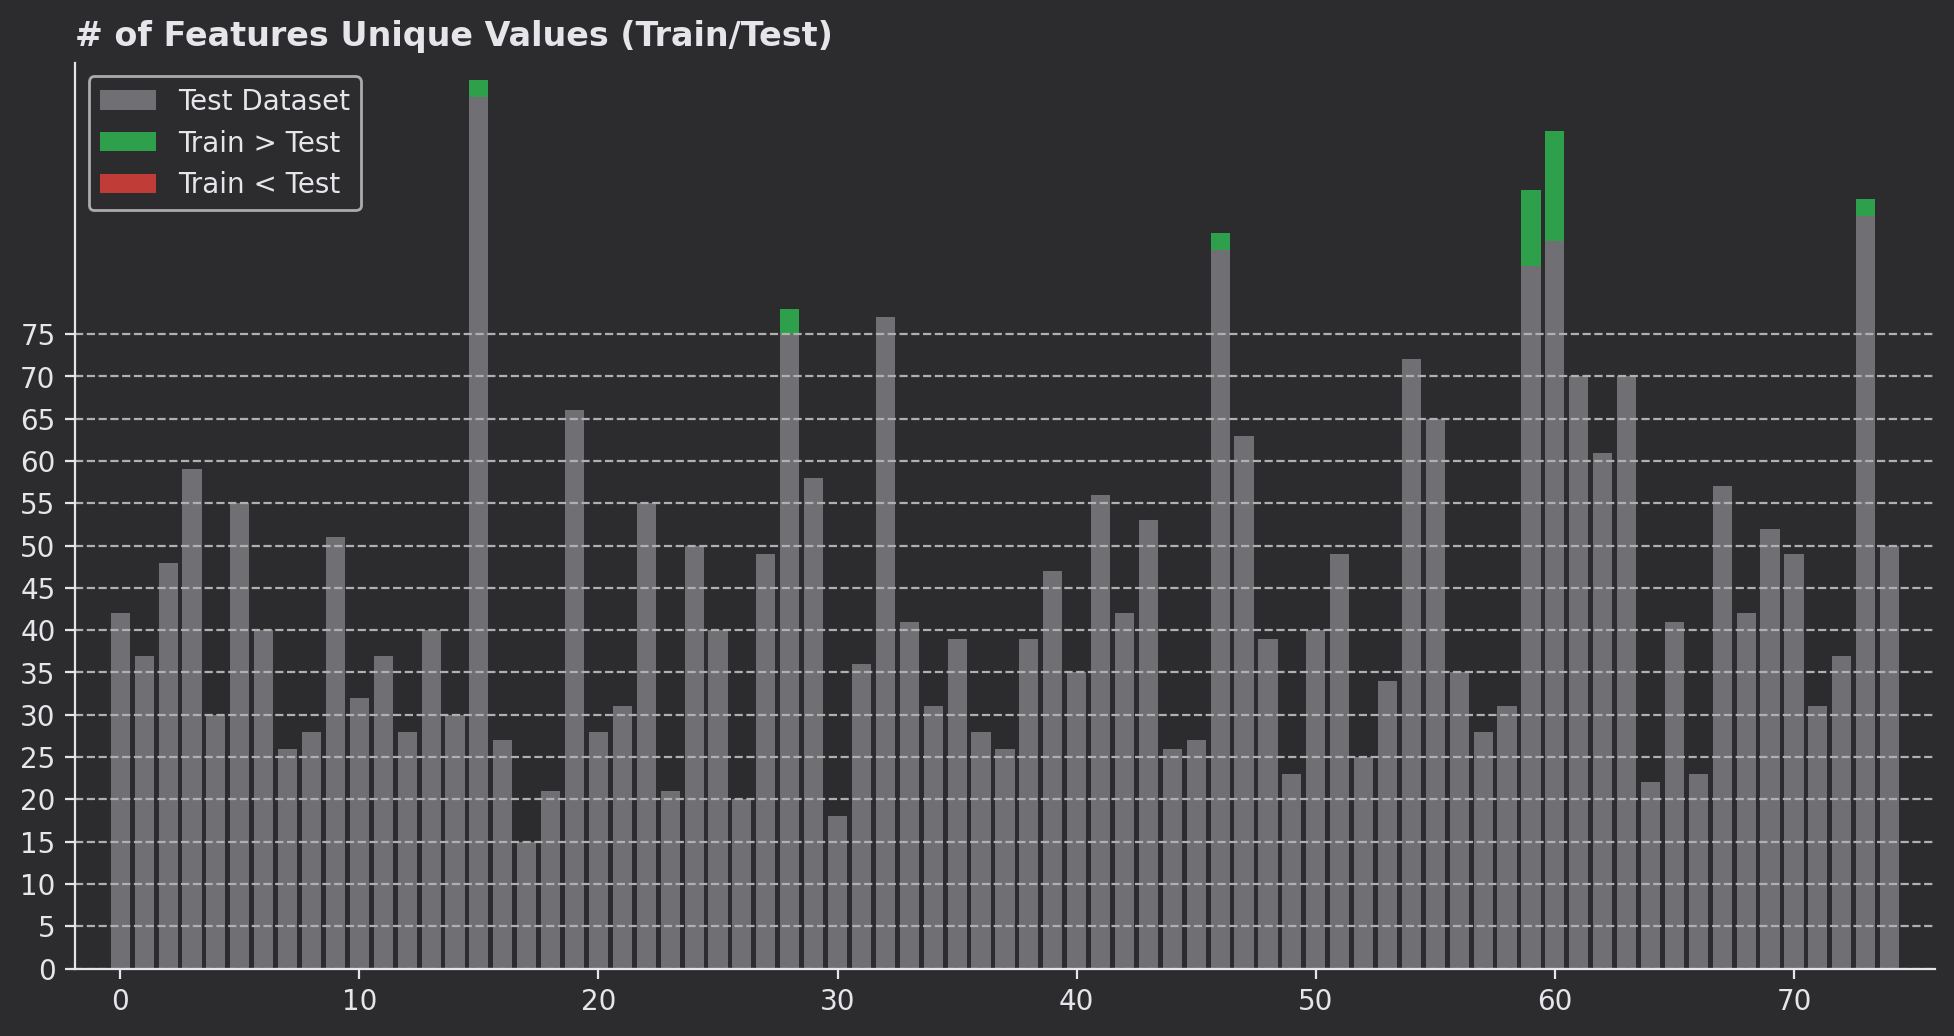

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
y = np.array([train[f'feature_{i}'].nunique() for i in range(75)])
y2 = np.array([test[f'feature_{i}'].nunique() for i in range(75)])
comp = y-y2
ax.bar(range(75), y2, alpha=0.7, color=gray_dark_palette[0], label='Test Dataset')
# Thanks to @rahulchauhan3j to fix typo
ax.bar(range(75),  comp*(comp>0), bottom=y2, color=dark_palette[2], alpha=0.7, label='Train > Test')
ax.bar(range(75), comp*(comp<0), bottom=y2-comp*(comp<0), color=dark_palette[3], alpha=0.7, label='Train < Test')
ax.set_yticks(range(0, 80, 5))
ax.margins(0.02)
ax.grid(axis='y', linestyle='--', zorder=5)
ax.set_title('# of Features Unique Values (Train/Test)', loc='left', fontweight='bold')
ax.legend()
plt.show()

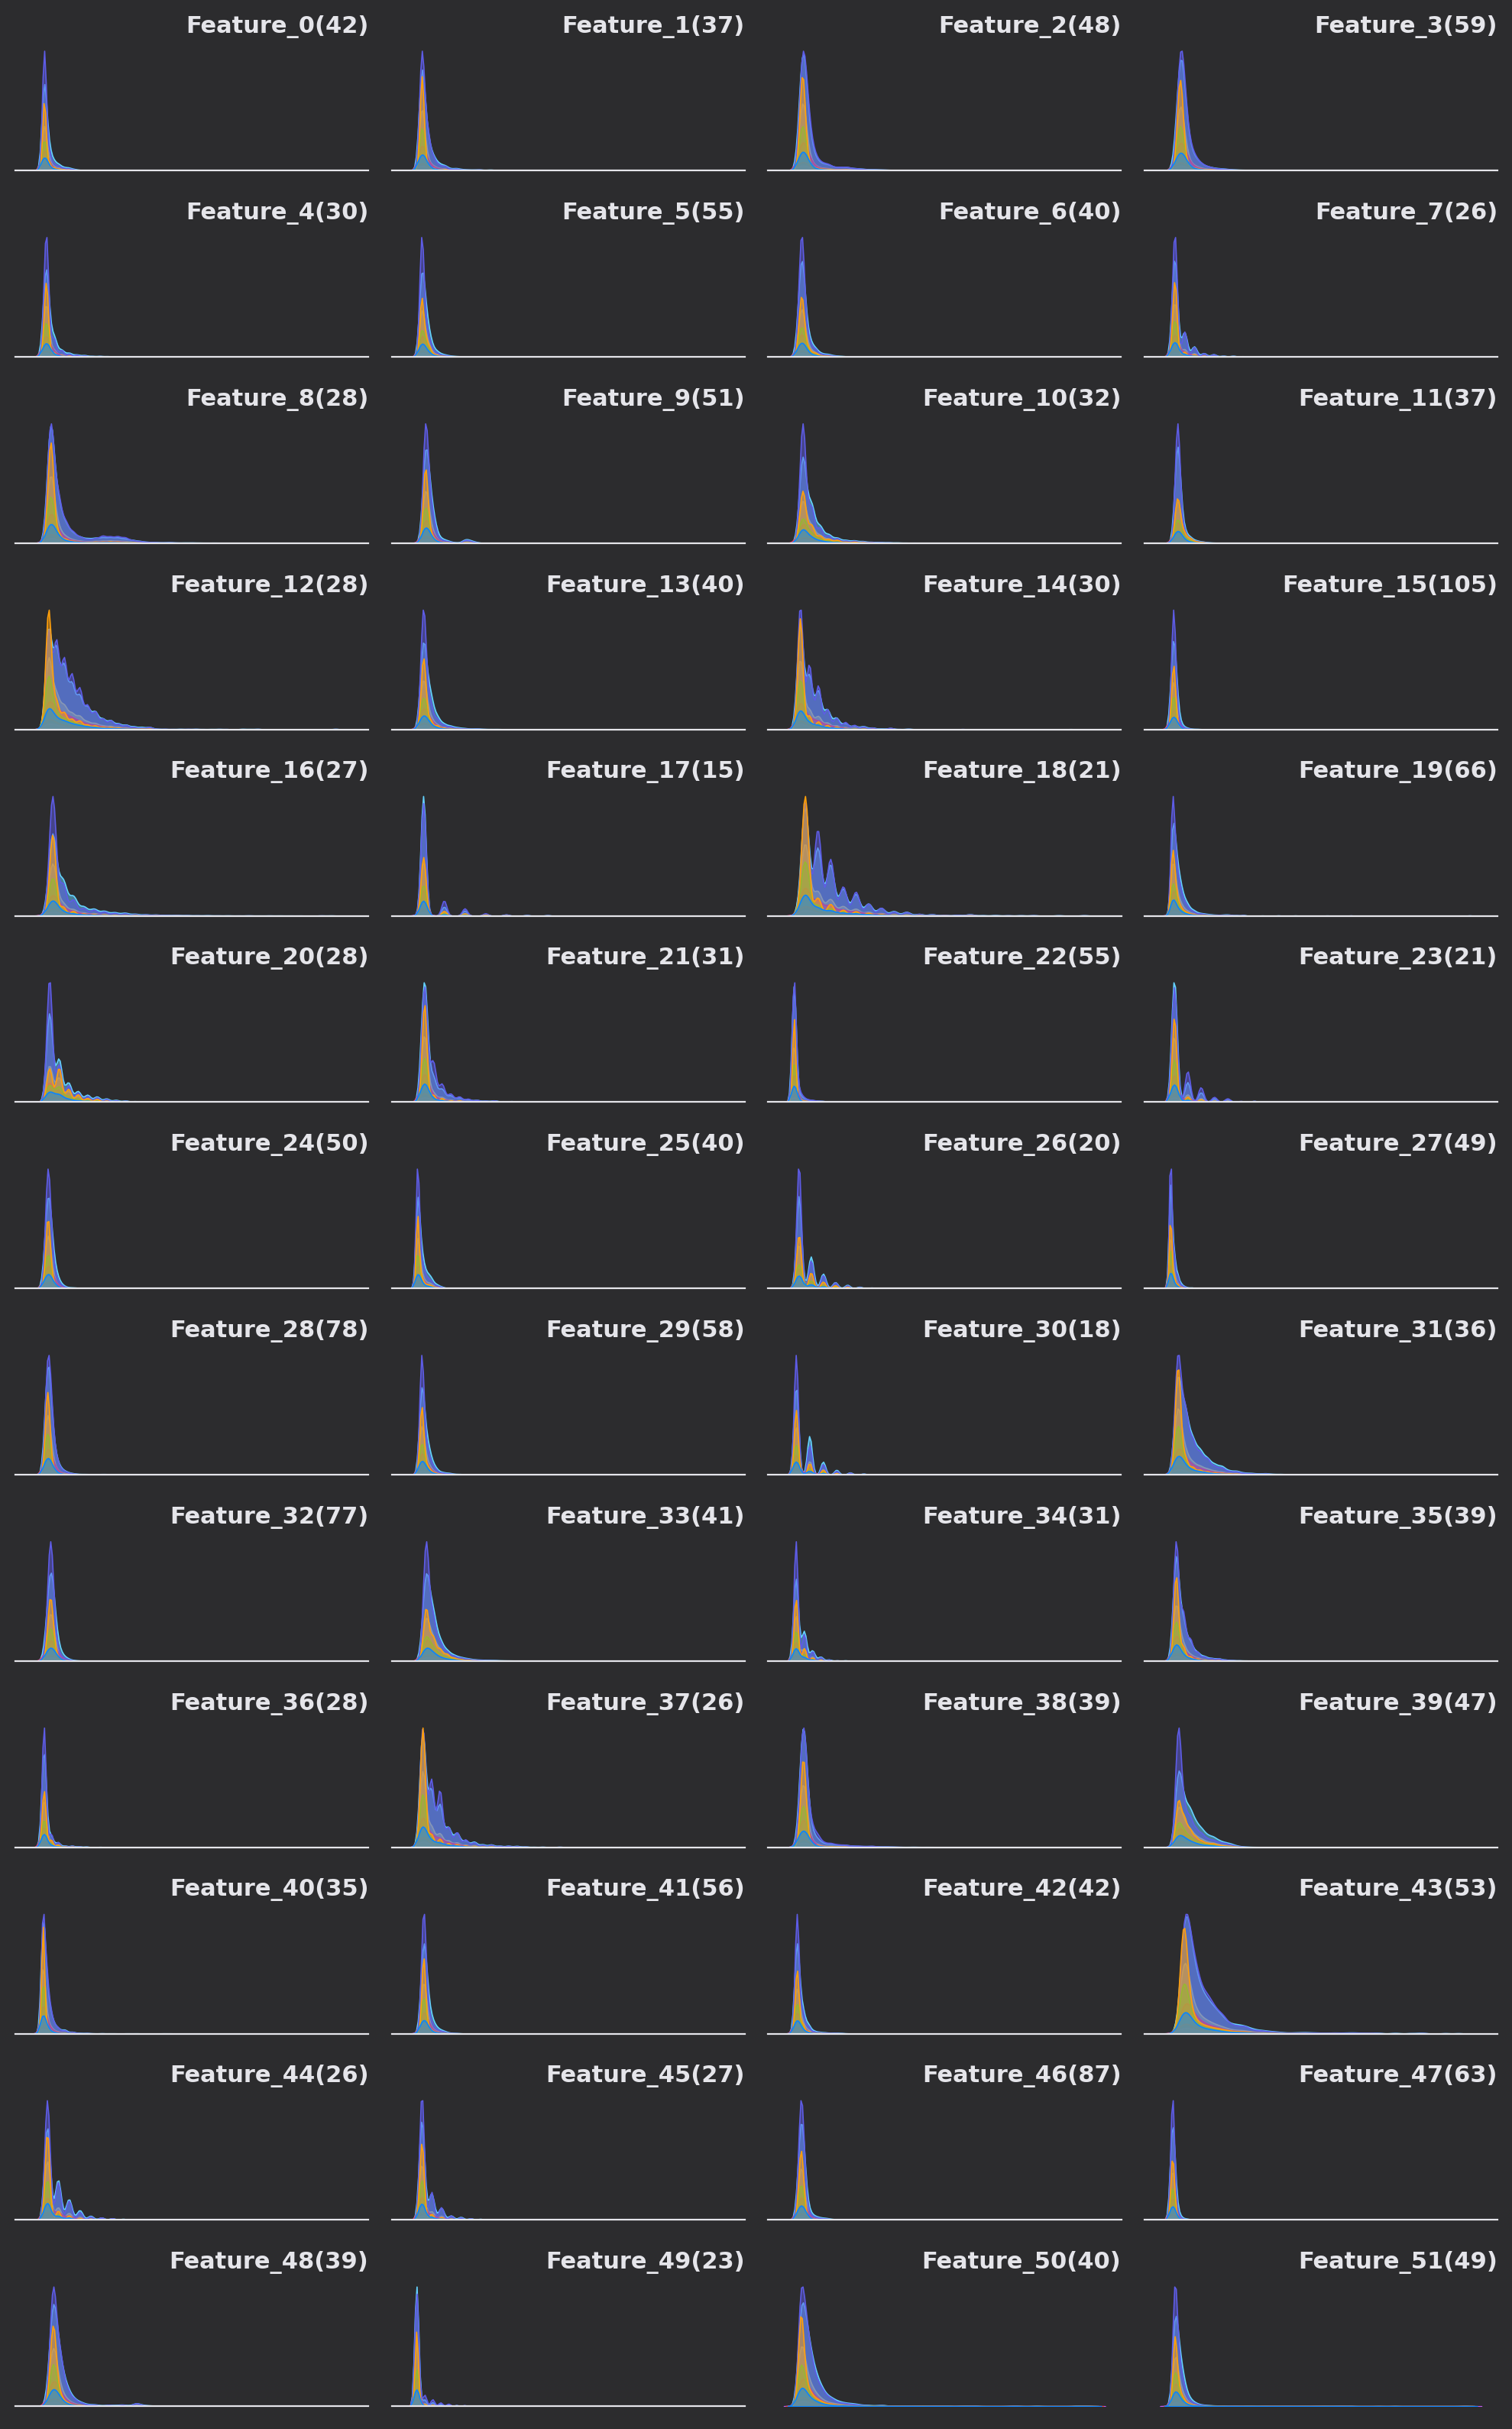

In [ ]:
fig, axes = plt.subplots(13, 4, figsize=(10, 16))
target_order = sorted(train['target'].unique())

for idx, ax in zip(range(75), axes.flatten()):
    cnt = train[f'feature_{idx}'].value_counts().sort_index()
    sns.kdeplot(x=f'feature_{idx}', 
    hue='target', hue_order=target_order,
    data=train,
    alpha=0.5, 
    linewidth=0.6, fill=True,
    legend=False,
    ax=ax)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    cnt = len(train[f'feature_{idx}'].unique())
    ax.set_title(f'Feature_{idx}({cnt})', loc='right', weight='bold', fontsize=11)

axes.flatten()[-1].axis('off')    
axes.flatten()[-2].axis('off')

fig.tight_layout()
plt.show()

In [ ]:
class variables:
    def _init_(self,data):
        self.data=data
    def statistics(self,data,combined):
        combined['sum']=data.sum(1)
        combined['avg']=data.mean(1)
        combined['max']=data.max(1)
        combined['min']=data.min(1)
        combined['median']=data.median(1)
        combined['std']=data.std(1)
        combined['count0']=data.isin([0]).sum(1)
        return combined

In [ ]:
y=train.target
one_hot_y=pd.get_dummies(y)
train.drop(['target','id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)
train_test=pd.concat([train,test])
ytrain=preprocessing.LabelEncoder().fit_transform(y)

In [ ]:
train_test.reset_index(drop=True,inplace=True)
ordinal=preprocessing.OrdinalEncoder().fit(train_test)
x=pd.DataFrame(ordinal.transform(train_test),columns=train.columns)
x_dummy=pd.get_dummies(x,columns=train_test.columns)
x=variables().statistics(train_test,x)
x_std=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(train_test),columns=train_test.columns)
x_std.columns=[i+'_std' for i in train_test.columns]
for i in train_test.columns:
  name = i+'_0'
  x[name] = train_test[i].apply(lambda x: 1 if x > 0 else 0)
x_con=pd.concat([x,x_std],axis=1)

In [ ]:
def lb_opt(xtrain,ytrain,trial):
    max_depth = trial.suggest_int('max_depth',2,5),
    learning_rate = trial.suggest_loguniform('learning_rate',0.01,0.1),
    n_estimators = trial.suggest_int('n_estimators',100,1000),
    reg_lambda =trial.suggest_float('reg_lambda',0.,3.)
    reg_alpha = trial.suggest_float('reg_alpha',0.,3.)
    subsample = trial.suggest_float('subsample',0.4,1.)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.4,1.)
    lightgbm_tuna = lgb.LGBMClassifier(
        random_state = 0,
        verbosity = 1,
        bagging_seed = 0,
        metric = 'binary_logloss',
        reg_alpha = reg_alpha,
        reg_lambda =reg_lambda,
        max_depth = max_depth,
        learning_rate = learning_rate,
        colsample_bytree=colsample_bytree,
        subsample = subsample
    )
    kf=KFold(n_splits=5, random_state=23, shuffle=True)
    scores = cross_val_score(lightgbm_tuna,xtrain,ytrain,scoring='neg_log_loss',cv=kf)
    score = -round(scores.mean(),3)
    return score

In [ ]:
out=pd.DataFrame()
out2=pd.DataFrame()
num = 200
for i in range(9):
  lgbm = lgb.LGBMClassifier()
  lgbm.fit(x_con.iloc[:200000,:],one_hot_y.iloc[:,i])
  booster = lgbm.booster_
  importance = booster.feature_importance(importance_type='split')
  feature_name = booster.feature_name()
  feature_importance = pd.DataFrame({'feature_name':feature_name,'importance':importance} )
  feature_importance.sort_values(by='importance',ascending=False,inplace=True)
  x_final_select=x_con.iloc[:200000,:][feature_importance.iloc[:num,0]]
  x_test=x_con.iloc[200000:,:][feature_importance.iloc[:num,0]]
  feature_list=['feature_54','feature_53']
  ''' 
  x_add=pd.DataFrame()
  for idx,first in enumerate(feature_list):
    for idx2,second in enumerate(feature_list):
      if(idx<idx2):
        pd_first=pd.get_dummies(x_final_select[first])
        pd_second=pd.get_dummies(x_final_select[second])
        for col in pd_first.columns:
          for col2 in pd_second.columns:
            name=str(col)+'*'+str(col2)
            x_add[name]=pd_first[col]*pd_second[col2]

  x_add_test=pd.DataFrame()
  for idx,first in enumerate(feature_list):
    for idx2,second in enumerate(feature_list):
      if(idx<idx2):
        pd_first=pd.get_dummies(x_test[first])
        pd_second=pd.get_dummies(x_test[second])
        for col in pd_first.columns:
          for col2 in pd_second.columns:
            name=str(col)+'*'+str(col2)
            x_add_test[name]=pd_first[col]*pd_second[col2]
  x_final_select=pd.concat([x_final_select,x_add],axis=1)
  x_test=pd.concat([x_test,x_add_test],axis=1)
  print(x_test)
  print(x_final_select)

  optuna.logging.disable_default_handler()
  lb_study = optuna.create_study()
  lb_study.optimize(functools.partial(lb_opt,x_final_select,one_hot_y.iloc[:,i]),n_trials = 10)
  '''
  lgbm = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8, importance_type='split',
               learning_rate=0.03, max_depth=3,
               min_child_samples=30, min_child_weight=0.001, min_split_gain=0.5,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=3.5,
               reg_lambda=3.5, silent=True,
               subsample=0.5, subsample_for_bin=200000,
               subsample_freq=0)
  lgbm.fit(x_final_select,one_hot_y.iloc[:,i])
  tmp=pd.DataFrame(lgbm.predict_proba(x_test))
  tmp2=pd.DataFrame(lgbm.predict_proba(x_final_select))
  out=pd.concat([out,tmp.iloc[:,1]],axis=1)
  out2=pd.concat([out2,tmp2.iloc[:,1]],axis=1)
  print(i)

In [ ]:
print(feature_importance.iloc[:10,0])

75           sum
80           std
81        count0
54    feature_54
53    feature_53
43    feature_43
20    feature_20
2      feature_2
77           max
12    feature_12
Name: feature_name, dtype: object


In [ ]:
from sklearn.metrics import log_loss
print(log_loss(one_hot_y,out2))

1.7066553271518103


In [ ]:
def xgb_opt(xtrain,ytrain,trial):

    max_depth = trial.suggest_int('max_depth',1,5)
    learning_rate = trial.suggest_loguniform('learning_rate',0.01,0.1)
    n_estimators = trial.suggest_int('n_estimators',100,1000)
    reg_lambda =trial.suggest_float('reg_lambda',0.,3.)
    reg_alpha = trial.suggest_float('reg_alpha',0.,3.)
    subsample = trial.suggest_float('subsample',0.4,1.)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.4,1.)
    xgb_tuna = xgb.XGBClassifier(
        random_state = 0,
        verbosity = 1,
        bagging_seed = 0,
        metric = 'binary_logloss',
        reg_alpha = reg_alpha,
        reg_lambda =reg_lambda,
        max_depth = max_depth,
        learning_rate = learning_rate,
        colsample_bytree=colsample_bytree,
        subsample = subsample
    )
    kf=KFold(n_splits=5, random_state=23, shuffle=True)
    scores = cross_val_score(xgb_tuna,xtrain,ytrain,scoring='neg_log_loss',cv=kf)
    score = -round(scores.mean(),3)
    return score

In [ ]:
'''
out2=pd.DataFrame()
num = 200
for i in range(9):
  xgbm = xgb.XGBClassifier()
  xgbm.fit(x_con.iloc[:200000,:],one_hot_y.iloc[:,i])
  feature_importance = pd.DataFrame({'feature_name':x_con.columns,'importance':xgbm.feature_importances_} )
  feature_importance.sort_values(by='importance',ascending=False,inplace=True)
  x_final_select=x_con.iloc[:200000,:][feature_importance.iloc[:num,0]]
  optuna.logging.disable_default_handler()
  lb_study = optuna.create_study()
  lb_study.optimize(functools.partial(xgb_opt,x_final_select,one_hot_y.iloc[:,i]),n_trials = 10)
  xgbm = xgb.XGBClassifier(**lb_study.best_params) 
  xgbm.fit(x_final_select,one_hot_y.iloc[:,i])
  tmp=pd.DataFrame(xgbm.predict_proba(x_con.iloc[200000:,:][feature_importance.iloc[:num,0]]))
  out2=pd.concat([out,tmp.iloc[:,1]],axis=1)
  print(i)
'''

In [ ]:
for i in range(9):
  sample_submission.iloc[:,i+1]=out.iloc[:,i]
sample_submission.to_csv('upload.csv',index=False)

In [ ]:
!kaggle competitions submit -c tabular-playground-series-jun-2021 -f upload.csv -m "upload"